***
## **<center>Recommender System</center>**

### <center> **Data Preprocessing, Model Training & Results</center>**

***


### **1. Configuration and Importing Required Libraries**

In [1]:
# Start Spark Session & import other libraries
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('project-recommender-system').getOrCreate()

import os
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pdb

import pyspark.sql.functions as F
import pyspark as ps
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from distributed import Client
from dask_jobqueue import SLURMCluster

# Random Seed
SEED = 1492


22/05/17 15:55:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/home/ax2047/.local/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:

# Choosing which dataset to use for processing
# dataset = "ml-latest"
dataset = "ml-latest-small"

# Path to Data Folder
datapath = "/scratch/work/courses/DSGA1004-2021/movielens/{0}".format(dataset)


### **2. Data Preprocessing**

In [3]:
class MovieLensDatasets(object):
    """
    Class for loading and preprocesing MovieLens Dataset
    """
    def __init__(self, ratings, movies, links):
        
        self.ratings = ratings
        self.movies = movies
        self.links = links

        # Create New DataFrame
        users = ratings.select('userId').distinct()
        self.users = users

    def preprocessing(self):
        # Preprocess MovieLens Ratings
        self.ratings = self.ratings.withColumn('rating',
              F.col('rating').cast('double')).drop('timestamp') \
              .withColumn('userId', F.col('userId').cast('int')) \
              .withColumn('movieId', F.col('movieId').cast('int'))


        # Binarize MovieLens Ratings (if rating >= 3.0, then 1.0, else 0.0)
        udf_scale_ratings = F.udf(lambda x: x - 2.5, DoubleType())
        udf_binary_ratings = F.udf(lambda x: 1.0 if x > 0.0 else 0.0, DoubleType())

        self.ratings = self.ratings \
        .withColumn('ratingsScaled', udf_scale_ratings(F.col('rating'))) \
        .withColumn('ratingsBinary', udf_binary_ratings(F.col('ratingsScaled'))) 

    def get_ratings(self):
        return self.ratings

    def get_movies(self):
        return self.movies

    # Displaying Null Values
    def spark_df_display_null_values(sparkDf):
        print('NaN values ?')
        sparkDf.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in sparkDf.columns]).show()

        print('Null values ?')
        sparkDf.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in sparkDf.columns]).show()

In [4]:
# Load Datasets
movies = spark.read.csv('{0}/movies.csv'.format(datapath),
                        header=True,       # use headers or not
                        quote='"',         # char for quotes
                        sep=",",           # char for separation
                        inferSchema=True
                       )

links = spark.read.csv('{0}/links.csv'.format(datapath),
                        header=True,       # use headers or not
                        quote='"',         # char for quotes
                        sep=",",           # char for separation
                        inferSchema=True)

ratings = spark.read.csv('{0}/ratings.csv'.format(datapath),
                        header=True,       # use headers or not
                        quote='"',         # char for quotes
                        sep=",",           # char for separation
                        inferSchema=True)

# Data Preprocessing
movieLensDatasets = MovieLensDatasets(ratings=ratings, movies=movies,
                                      links=links)

movieLensDatasets.preprocessing()
dfRatings = movieLensDatasets.get_ratings() 
dfMovies = movieLensDatasets.get_movies()

### **3. Model Training**
***

### **3.1. Train, Validation, Test Data Split**

In [5]:
ratingsPrepare = dfRatings.withColumn("userId", F.col("userId").cast('int')) \
                          .withColumn("movieId", F.col("movieId").cast('int'))

training_df, validation_df, testing_df = ratingsPrepare.randomSplit([0.6, 0.2, 0.2],
                                                           seed=SEED)


In [6]:
training_users_unique_id = list(set(training_df.select("userId").rdd.flatMap(lambda x: x).collect()))

### **3.2. Defining Our Accuracy Metrics**



In [7]:
### Accuracy Metrics
def catalog_coverage(predicted, catalog, k):
    """
    Computes the catalog coverage for k lists of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    Returns
    ----------
    catalog_coverage:
        The catalog coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and
    serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems
    (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = L_predictions/(len(catalog)*1.0)
    return catalog_coverage


def get_rec_sys_results(relevantDocumentsDf, dfMovies):
    """
    Returns dictionnary of recommender system metrics
    Since Spark ML DataFrame-based doesn't have a
    specific function for evaluating the soundness
    of item recommendations, we will have to use
    Spark MLlib RDD-based API
    """
    # Transform Spark Dataframe into Spark RDD
    relevantDocuments = relevantDocumentsDf.rdd \
        .map(lambda row: (row.predictions, row.groundTruth))
    
    # Get Catalog Coverage
    moviesCatalog = dfMovies.select("movieId") \
                            .orderBy("movieId") \
                            .distinct() \
                            .toPandas()
    predictions = relevantDocumentsDf.select("predictions").toPandas()
    predictionsList = predictions.values.tolist()
    predictionsList = [sublist[0] for sublist in predictionsList]
    cc = catalog_coverage(predicted=predictionsList,
                          catalog=moviesCatalog, k=100)

    # Get Results
    metrics = RankingMetrics(relevantDocuments)
    pk100 = metrics.precisionAt(100)
    ndcg100 = metrics.ndcgAt(100)
    
    # TODO: Search and Add more Ranking Metrics
    
    results = dict(Pk100=pk100, NDCGk100=ndcg100, CC=cc)
    
    return results


def format_recommendations(rowPreds):
    # From recommendations column extract only items
    # recommended and ignore ratings
    rowPredsList = [row.movieId for row in rowPreds]
    return rowPredsList

udf_format_recommendations = F.udf(lambda x: format_recommendations(x),
                                   ArrayType(IntegerType()))

### **3.3. Popularity-Based Model**

In [8]:
class PopularityRecommenderModel(object):
    """
    Class for generating movie item recommendations based on movie popularity
    (from average ratings with logarithmic scaling factor that penalizes movies
    with few ratings). By default, only the top 10 rated movies are selected.
    """
    
    def __init__(self, ratingsTrain, ratingsValidation):
        self.ratingsTrain = ratingsTrain
        self.ratingsValidation = ratingsValidation

    def generate_recommendations_for_all_users(self, topk=10):
        # Get list of top k rated movies
        topRated = self._get_top_k_best_movies(topk=topk)

        # Compare most popular movies with user's personal preferences
        # Important: only keep recommendations with rating over 3/5
        # Important: Removed any userid which is not in training dataset
        results = self.ratingsValidation \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .filter(F.col("userId").isin(training_users_unique_id)) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .orderBy('rating', ascending=False) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias('groundTruth')) \
                 .withColumn('predictions', F.array([F.lit(el)
                        for el in topRated])) \
                 .select(['userId', 'predictions', 'groundTruth'])

        return results

    def _get_top_k_best_movies(self, topk):

        # Function
        def _get_mean_rating_w_log_penalty(arr):
            sumRatings, nbRatings = arr[0], arr[1]
            grade = (sumRatings / nbRatings) * math.log(nbRatings)
            return grade

        # UDF
        udf_mean_rating_w_log_penalty = F.udf(
            lambda arr: _get_mean_rating_w_log_penalty(arr),
            DoubleType()
        )

        # Get top k Best Rated Movies
        ranking = self.ratingsTrain.groupBy('movieId') \
                  .agg({'rating': 'sum', 'userId': 'count'}) \
                  .toDF('movieId', 'sumRating', 'nbRatings')

        ranking = ranking \
          .withColumn("meanLogUserRating",
             udf_mean_rating_w_log_penalty(F.array("sumRating", "nbRatings"))
             ) \
          .sort(['meanLogUserRating', 'nbRatings'], ascending=[False, True]) \
          .limit(topk)

        self.topRatedMovies = ranking
        ratingsTop = [int(row.movieId) for row in ranking.collect()]

        return ratingsTop

In [9]:
# Generating recommendations for each user based on our popularity model (Validation Dataset)

pbrModel = PopularityRecommenderModel(training_df, validation_df)
resultsPop = pbrModel.generate_recommendations_for_all_users(topk=100)

In [10]:
# Generating recommendations for each user based on our popularity model (Test Dataset)

pbrModel_test = PopularityRecommenderModel(training_df, testing_df)
resultsPop_test = pbrModel.generate_recommendations_for_all_users(topk=100)

In [11]:
resultsPop.limit(5).orderBy('userId').show(5)

+------+--------------------+--------------------+
|userId|         predictions|         groundTruth|
+------+--------------------+--------------------+
|   148|[318, 356, 593, 2...|[116797, 160718, ...|
|   243|[318, 356, 593, 2...|[172, 44, 48, 420...|
|   463|[318, 356, 593, 2...|[1552, 1690, 5010...|
|   471|[318, 356, 593, 2...|[2324, 60069, 784...|
|   496|[318, 356, 593, 2...|[106920, 7153, 36...|
+------+--------------------+--------------------+



In [12]:
results = get_rec_sys_results(resultsPop, dfMovies)

/home/ax2047/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [13]:
results

{'Pk100': 0.04724422442244223,
 'NDCGk100': 0.1566032398580673,
 'CC': 0.010264832683227263}

In [14]:
results_test = get_rec_sys_results(resultsPop_test, dfMovies)

In [15]:
results_test

{'Pk100': 0.04724422442244226,
 'NDCGk100': 0.15660323985806723,
 'CC': 0.010264832683227263}

In [16]:
# Highest rated movies
pbrModel.topRatedMovies \
    .join(dfMovies.select(['movieId', 'title']), 'movieId') \
    .orderBy('meanLogUserRating', ascending=False) \
    .show(100, truncate=False)

+-------+---------+---------+------------------+------------------------------------------------------------------------------+
|movieId|sumRating|nbRatings|meanLogUserRating |title                                                                         |
+-------+---------+---------+------------------+------------------------------------------------------------------------------+
|318    |825.5    |187      |23.092407289911556|Shawshank Redemption, The (1994)                                              |
|356    |847.5    |205      |22.006102230828297|Forrest Gump (1994)                                                           |
|593    |730.0    |173      |21.74510326001953 |Silence of the Lambs, The (1991)                                              |
|2571   |766.0    |185      |21.615094929783766|Matrix, The (1999)                                                            |
|296    |741.0    |179      |21.474038447642457|Pulp Fiction (1994)                                     

### **3.4. Model Based Collaborative Filtering**



#### **3.4.1 Model Training  with RMSE on Test Set**

In [17]:
ranks = range(4, 12)
regParam = [0.01, 0.1]
errors = []
min_error = float('inf')
for param in regParam:
    for rank in ranks:
        
        tempALS = ALS(maxIter=10, rank=rank, regParam=param, nonnegative=True,
              userCol='userId', itemCol='movieId', ratingCol='rating',
              coldStartStrategy='drop', implicitPrefs=False, seed=SEED)

        model = tempALS.fit(training_df)
        
        predictions = model.transform(validation_df)
        evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
        rmse = evaluator.evaluate(predictions)
        errors.append(rmse)
        print ('For rank {0} and regParam {1} the RMSE is {2}'.format (rank, param, rmse))
        
        if rmse < min_error:
            min_error = rmse
            best_rank = rank
            best_regParam = param
            best_model = model
        
print ('The best model was trained with rank {0} and regParam {1}'.format(best_rank, best_regParam))
    


22/05/17 15:55:40 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/17 15:55:40 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


For rank 4 and regParam 0.01 the RMSE is 1.0016021771316816


For rank 5 and regParam 0.01 the RMSE is 1.0301192935235441


For rank 6 and regParam 0.01 the RMSE is 1.0311335725565325


For rank 7 and regParam 0.01 the RMSE is 1.0294362722679846


For rank 8 and regParam 0.01 the RMSE is 1.0552924507643928


For rank 9 and regParam 0.01 the RMSE is 1.050572920701859


For rank 10 and regParam 0.01 the RMSE is 1.057220782829928


For rank 11 and regParam 0.01 the RMSE is 1.0684831042429928


For rank 4 and regParam 0.1 the RMSE is 0.8958442506792226


For rank 5 and regParam 0.1 the RMSE is 0.898062619417609


For rank 6 and regParam 0.1 the RMSE is 0.9013573999739966


For rank 7 and regParam 0.1 the RMSE is 0.8964614013038112


For rank 8 and regParam 0.1 the RMSE is 0.89590571096802


For rank 9 and regParam 0.1 the RMSE is 0.9013159052706687


For rank 10 and regParam 0.1 the RMSE is 0.8987670363474984


For rank 11 and regParam 0.1 the RMSE is 0.9003057135286106
The best model was trained with rank 4 and regParam 0.1


#### **3.4.2 Evaluating Recommendations**

In [18]:
resultsALS = best_model.recommendForAllUsers(100)

resultsALS = resultsALS.withColumn('recommendations',
              udf_format_recommendations(F.col("recommendations"))) \
              .toDF('userId', 'predictions')

In [19]:
resultsALS.limit(5).orderBy('userId').show(5)

+------+--------------------+
|userId|         predictions|
+------+--------------------+
|   148|[6433, 86377, 177...|
|   463|[177593, 3819, 64...|
|   471|[6818, 148881, 35...|
|   496|[5485, 7121, 2632...|
|   540|[177593, 3030, 84...|
+------+--------------------+



In [20]:
# Most frequently recommended movies
resultsALSExpanded = resultsALS \
                        .withColumn("movieId", F.explode("predictions")) \
                        .drop('predictions') \
                        .join(dfMovies, "movieId")

MostRecommendedMoviesForAllUsers = resultsALSExpanded.groupby(["movieId", "title"]).agg({'userId':'count'})
MostRecommendedMoviesForAllUsers = MostRecommendedMoviesForAllUsers.sort(['count(userId)'], ascending=False)

In [21]:
MostRecommendedMoviesForAllUsers.show(5)

+-------+--------------------+-------------+
|movieId|               title|count(userId)|
+-------+--------------------+-------------+
| 177593|Three Billboards ...|          560|
|   7121|   Adam's Rib (1949)|          531|
|  33649|  Saving Face (2004)|          528|
|   6732|Hello, Dolly! (1969)|          488|
|   3030|      Yojimbo (1961)|          461|
+-------+--------------------+-------------+
only showing top 5 rows



In [22]:
# Verifying if the CF-ALS recommendations are consistent with the user's tastes
resultsALS_validation = resultsALS \
                 .join(
                 validation_df \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias("groundTruth")),
                     'userId'
                 )

resultsALS_test = resultsALS \
                 .join(
                 testing_df \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias("groundTruth")),
                     'userId'
                 )

In [23]:
resultsALS_validation.limit(5).orderBy('userId').show(5)

+------+--------------------+--------------------+
|userId|         predictions|         groundTruth|
+------+--------------------+--------------------+
|   148|[6433, 86377, 177...|[4886, 7153, 4419...|
|   463|[177593, 3819, 64...|[1552, 1690, 3448...|
|   471|[6818, 148881, 35...|[2324, 4886, 6006...|
|   496|[5485, 7121, 2632...|[3668, 7153, 1069...|
|   540|[177593, 3030, 84...|[1409, 2028, 2747...|
+------+--------------------+--------------------+



In [24]:
resultsALSMetrics = get_rec_sys_results(resultsALS_validation, dfMovies)

In [25]:
resultsALSMetrics_test = get_rec_sys_results(resultsALS_test, dfMovies)

In [26]:
resultsALSMetrics

{'Pk100': 0.0015346534653465351,
 'NDCGk100': 0.003904072025096909,
 'CC': 0.0847875179634572}

In [27]:
resultsALSMetrics_test

{'Pk100': 0.0014545454545454542,
 'NDCGk100': 0.0035176941454152988,
 'CC': 0.09484705399301992}

## **3.5. Results**

**3.5.1 Performance Evaluation Comparisons on validation Data**

In [28]:
results['RMSE'] = 'N/A'
resultsALSMetrics['RMSE'] = min_error

In [29]:
modelResults = pd.DataFrame([results, resultsALSMetrics],
                             index=['Popularity Reccomender', 'Collaborative Filteirng - ALS'])

modelResults.transpose()

,Popularity Reccomender,Collaborative Filteirng - ALS
Pk100,0.047244,0.001535
NDCGk100,0.156603,0.003904
CC,0.010265,0.084788
RMSE,N/A,0.895844


**3.5.2 Performance Evaluation Comparisons on Test Data**

In [30]:
results_test['RMSE'] = 'N/A'

In [31]:
predictions = best_model.transform(testing_df)
#best_model.recommendForUserSubset(100) 
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
resultsALSMetrics_test['RMSE'] = rmse

In [32]:
modelResults = pd.DataFrame([results_test, resultsALSMetrics_test],
                             index=['Popularity Reccomender', 'Collaborative Filteirng - ALS'])

modelResults.transpose()

,Popularity Reccomender,Collaborative Filteirng - ALS
Pk100,0.047244,0.001455
NDCGk100,0.156603,0.003518
CC,0.010265,0.094847
RMSE,N/A,0.910295


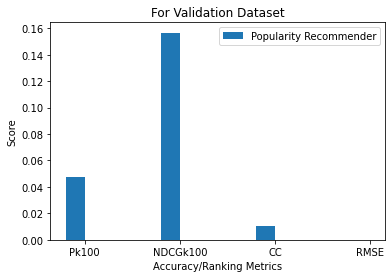

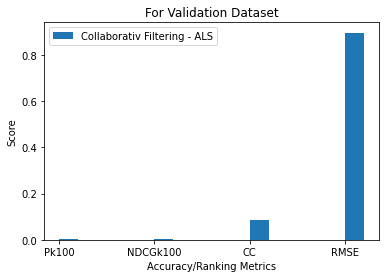

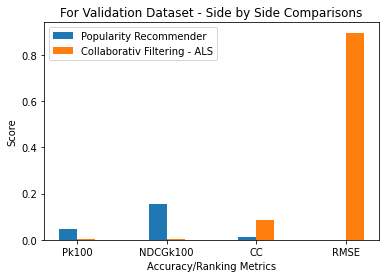

In [33]:
results['RMSE'] = 0

X = ['Pk100','NDCGk100','CC','RMSE']
popRec = results.values()
alsRec = resultsALSMetrics.values()
  
X_axis = np.arange(len(X))
plt.figure(1)  
plt.bar(X_axis - 0.1, popRec, 0.2, label = 'Popularity Recommender')
plt.xticks(X_axis, X)
plt.xlabel("Accuracy/Ranking Metrics")
plt.ylabel("Score")
plt.title("For Validation Dataset")
plt.legend()
plt.show()

plt.figure(2)
plt.bar(X_axis + 0.1, alsRec, 0.2, label = 'Collaborativ Filtering - ALS')
plt.xticks(X_axis, X)
plt.xlabel("Accuracy/Ranking Metrics")
plt.ylabel("Score")
plt.title("For Validation Dataset")
plt.legend()
plt.show()

plt.figure(3)
plt.bar(X_axis - 0.1, popRec, 0.2, label = 'Popularity Recommender')
plt.bar(X_axis + 0.1, alsRec, 0.2, label = 'Collaborativ Filtering - ALS')
plt.xticks(X_axis, X)
plt.xlabel("Accuracy/Ranking Metrics")
plt.ylabel("Score")
plt.title("For Validation Dataset - Side by Side Comparisons")
plt.legend()
plt.show()

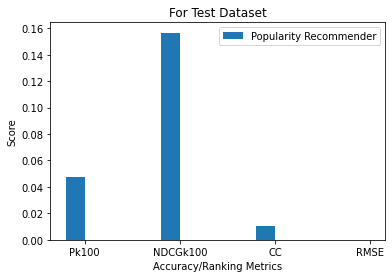

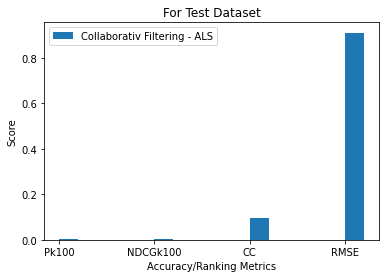

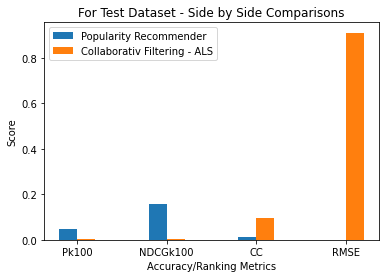

In [34]:
results_test['RMSE'] = 0

X = ['Pk100','NDCGk100','CC','RMSE']
popRec = results_test.values()
alsRec = resultsALSMetrics_test.values()
  
X_axis = np.arange(len(X))
plt.figure(4)  
plt.bar(X_axis - 0.1, popRec, 0.2, label = 'Popularity Recommender')
plt.xticks(X_axis, X)
plt.xlabel("Accuracy/Ranking Metrics")
plt.ylabel("Score")
plt.title("For Test Dataset")
plt.legend()
plt.show()

plt.figure(5)
plt.bar(X_axis + 0.1, alsRec, 0.2, label = 'Collaborativ Filtering - ALS')
plt.xticks(X_axis, X)
plt.xlabel("Accuracy/Ranking Metrics")
plt.ylabel("Score")
plt.title("For Test Dataset")
plt.legend()
plt.show()

plt.figure(6)
plt.bar(X_axis - 0.1, popRec, 0.2, label = 'Popularity Recommender')
plt.bar(X_axis + 0.1, alsRec, 0.2, label = 'Collaborativ Filtering - ALS')
plt.xticks(X_axis, X)
plt.xlabel("Accuracy/Ranking Metrics")
plt.ylabel("Score")
plt.title("For Test Dataset - Side by Side Comparisons")
plt.legend()
plt.show()

## **3.6. Extensions Done**

**3.6.1 ALS Benchmarking on Clusters and Single Machine**

**3.6.1.1 For Clusters**

In [35]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution

LOCAL = False

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=2, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

Task exception was never retrieved
future: <Task finished name='Task-43' coro=<_wrap_awaitable() done, defined at /ext3/pyspark/lib/python3.8/asyncio/tasks.py:688> exception=FileNotFoundError(2, 'No such file or directory')>
Traceback (most recent call last):
  File "/ext3/pyspark/lib/python3.8/asyncio/tasks.py", line 695, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/home/ax2047/.local/lib/python3.8/site-packages/distributed/deploy/spec.py", line 59, in _
    await self.start()
  File "/home/ax2047/.local/lib/python3.8/site-packages/dask_jobqueue/core.py", line 325, in start
    out = await self._submit_job(fn)
  File "/home/ax2047/.local/lib/python3.8/site-packages/dask_jobqueue/core.py", line 308, in _submit_job
    return self._call(shlex.split(self.submit_command) + [script_filename])
  File "/home/ax2047/.local/lib/python3.8/site-packages/dask_jobqueue/core.py", line 395, in _call
    proc = subprocess.Popen(
  File "/ext3/pyspark/lib/python3.8/subproc

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.32.35.54:8787/status,
Dashboard: http://10.32.35.54:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.32.35.54:33281,Workers: 0
Dashboard: http://10.32.35.54:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [36]:
%%time
ranks = range(4, 12)
regParam = [0.01, 0.1]
errors = []
min_error = float('inf')
for param in regParam:
    for rank in ranks:
        
        tempALS = ALS(maxIter=10, rank=rank, regParam=param, nonnegative=True,
              userCol='userId', itemCol='movieId', ratingCol='rating',
              coldStartStrategy='drop', implicitPrefs=False, seed=SEED)

        model = tempALS.fit(training_df)
        
        predictions = model.transform(validation_df)
        #best_model.recommendForUserSubset(100) 
        evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
        rmse = evaluator.evaluate(predictions)
        errors.append(rmse)
        print ('For rank {0} and regParam {1} the RMSE is {2}'.format (rank, param, rmse))
        
        if rmse < min_error:
            min_error = rmse
            best_rank = rank
            best_regParam = param
            best_model = model
        
print ('The best model was trained with rank {0} and regParam {1}'.format(best_rank, best_regParam))
    



For rank 4 and regParam 0.01 the RMSE is 1.0016021771316816


For rank 5 and regParam 0.01 the RMSE is 1.0301192935235441


For rank 6 and regParam 0.01 the RMSE is 1.0311335725565325


For rank 7 and regParam 0.01 the RMSE is 1.0294362722679846


For rank 8 and regParam 0.01 the RMSE is 1.0552924507643928


For rank 9 and regParam 0.01 the RMSE is 1.050572920701859


For rank 10 and regParam 0.01 the RMSE is 1.0572207828299283


For rank 11 and regParam 0.01 the RMSE is 1.0684831042429928


For rank 4 and regParam 0.1 the RMSE is 0.8958442506792226


For rank 5 and regParam 0.1 the RMSE is 0.8980626194176089


For rank 6 and regParam 0.1 the RMSE is 0.9013573999739966


For rank 7 and regParam 0.1 the RMSE is 0.8964614013038112


For rank 8 and regParam 0.1 the RMSE is 0.89590571096802


For rank 9 and regParam 0.1 the RMSE is 0.9013159052706686


For rank 10 and regParam 0.1 the RMSE is 0.8987670363474984


For rank 11 and regParam 0.1 the RMSE is 0.9003057135286106
The best model was trained with rank 4 and regParam 0.1
CPU times: user 1.34 s, sys: 738 ms, total: 2.07 s
Wall time: 56.8 s


In [37]:
%%time
resultsALS = best_model.recommendForAllUsers(100)

resultsALS = resultsALS.withColumn('recommendations',
              udf_format_recommendations(F.col("recommendations"))) \
              .toDF('userId', 'predictions')

CPU times: user 1.85 ms, sys: 2.9 ms, total: 4.75 ms
Wall time: 65.3 ms


/home/ax2047/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [38]:
%%time
resultsALS.limit(5).orderBy('userId').show(5)

+------+--------------------+
|userId|         predictions|
+------+--------------------+
|   148|[6433, 86377, 177...|
|   463|[177593, 3819, 64...|
|   471|[6818, 148881, 35...|
|   496|[5485, 7121, 2632...|
|   540|[177593, 3030, 84...|
+------+--------------------+

CPU times: user 56.7 ms, sys: 24.6 ms, total: 81.2 ms
Wall time: 2.1 s


In [39]:
%%time
# Most frequently recommended movies
resultsALSExpanded = resultsALS \
                        .withColumn("movieId", F.explode("predictions")) \
                        .drop('predictions') \
                        .join(dfMovies, "movieId")

MostRecommendedMoviesForAllUsers = resultsALSExpanded.groupby(["movieId", "title"]).agg({'userId':'count'})
MostRecommendedMoviesForAllUsers = MostRecommendedMoviesForAllUsers.sort(['count(userId)'], ascending=False)

CPU times: user 2.6 ms, sys: 1.65 ms, total: 4.26 ms
Wall time: 38.4 ms


In [40]:
%%time
MostRecommendedMoviesForAllUsers.show(5)

+-------+--------------------+-------------+
|movieId|               title|count(userId)|
+-------+--------------------+-------------+
| 177593|Three Billboards ...|          560|
|   7121|   Adam's Rib (1949)|          531|
|  33649|  Saving Face (2004)|          528|
|   6732|Hello, Dolly! (1969)|          488|
|   3030|      Yojimbo (1961)|          461|
+-------+--------------------+-------------+
only showing top 5 rows

CPU times: user 88.1 ms, sys: 43.3 ms, total: 131 ms
Wall time: 3.44 s


In [41]:
%%time
# Verifying if the CF-ALS recommendations are consistent with the user's tastes
resultsALS_validation = resultsALS \
                 .join(
                 validation_df \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias("groundTruth")),
                     'userId'
                 )

resultsALS_test = resultsALS \
                 .join(
                 testing_df \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias("groundTruth")),
                     'userId'
                 )

CPU times: user 3.75 ms, sys: 2.1 ms, total: 5.86 ms
Wall time: 40.8 ms


In [42]:
%%time
resultsALS_validation.limit(5).orderBy('userId').show(5)

+------+--------------------+--------------------+
|userId|         predictions|         groundTruth|
+------+--------------------+--------------------+
|   148|[6433, 86377, 177...|[4886, 7153, 4419...|
|   463|[177593, 3819, 64...|[1552, 1690, 3448...|
|   471|[6818, 148881, 35...|[2324, 4886, 6006...|
|   496|[5485, 7121, 2632...|[3668, 7153, 1069...|
|   540|[177593, 3030, 84...|[1409, 2028, 2747...|
+------+--------------------+--------------------+

CPU times: user 63.2 ms, sys: 34.4 ms, total: 97.6 ms
Wall time: 2.6 s


In [43]:
%%time
resultsALSMetrics = get_rec_sys_results(resultsALS_validation, dfMovies)

CPU times: user 282 ms, sys: 163 ms, total: 445 ms
Wall time: 7.23 s


In [44]:
%%time
resultsALSMetrics_test = get_rec_sys_results(resultsALS_test, dfMovies)

CPU times: user 201 ms, sys: 100 ms, total: 301 ms
Wall time: 7.3 s


In [45]:
%%time
resultsALSMetrics

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs


{'Pk100': 0.0015346534653465345,
 'NDCGk100': 0.00390407202509691,
 'CC': 0.0900225826319031}

In [46]:
%%time
resultsALSMetrics_test

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


{'Pk100': 0.0014545454545454545,
 'NDCGk100': 0.003517694145415304,
 'CC': 0.0814001231779922}

**3.6.1.2 For Single Machine**

In [47]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution

LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=14, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

/home/ax2047/.local/lib/python3.8/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44773 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44773/status,
Dashboard: http://127.0.0.1:44773/status,Workers: 5
Total threads: 10,Total memory: 512.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46469,Workers: 5
Dashboard: http://127.0.0.1:44773/status,Total threads: 10
Started: Just now,Total memory: 512.00 GiB
Comm: tcp://127.0.0.1:39189,Total threads: 2
Dashboard: http://127.0.0.1:36137/status,Memory: 102.40 GiB
Nanny: tcp://127.0.0.1:35803,


In [48]:
%%time
ranks = range(4, 12)
regParam = [0.01, 0.1]
errors = []
min_error = float('inf')
for param in regParam:
    for rank in ranks:
        
        tempALS = ALS(maxIter=10, rank=rank, regParam=param, nonnegative=True,
              userCol='userId', itemCol='movieId', ratingCol='rating',
              coldStartStrategy='drop', implicitPrefs=False, seed=SEED)

        model = tempALS.fit(training_df)
        
        predictions = model.transform(validation_df)
        #best_model.recommendForUserSubset(100) 
        evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
        rmse = evaluator.evaluate(predictions)
        errors.append(rmse)
        print ('For rank {0} and regParam {1} the RMSE is {2}'.format (rank, param, rmse))
        
        if rmse < min_error:
            min_error = rmse
            best_rank = rank
            best_regParam = param
            best_model = model
        
print ('The best model was trained with rank {0} and regParam {1}'.format(best_rank, best_regParam))
    




For rank 4 and regParam 0.01 the RMSE is 1.0016021771316816


For rank 5 and regParam 0.01 the RMSE is 1.0301192935235441


For rank 6 and regParam 0.01 the RMSE is 1.0311335725565327


For rank 7 and regParam 0.01 the RMSE is 1.0294362722679846


For rank 8 and regParam 0.01 the RMSE is 1.0552924507643926


For rank 9 and regParam 0.01 the RMSE is 1.050572920701859


For rank 10 and regParam 0.01 the RMSE is 1.057220782829928


For rank 11 and regParam 0.01 the RMSE is 1.0684831042429928


For rank 4 and regParam 0.1 the RMSE is 0.8958442506792226


For rank 5 and regParam 0.1 the RMSE is 0.8980626194176089


For rank 6 and regParam 0.1 the RMSE is 0.9013573999739966


For rank 7 and regParam 0.1 the RMSE is 0.8964614013038112


For rank 8 and regParam 0.1 the RMSE is 0.89590571096802


For rank 9 and regParam 0.1 the RMSE is 0.9013159052706686


For rank 10 and regParam 0.1 the RMSE is 0.8987670363474984


For rank 11 and regParam 0.1 the RMSE is 0.9003057135286106
The best model was trained with rank 4 and regParam 0.1
CPU times: user 4.03 s, sys: 3.2 s, total: 7.23 s
Wall time: 57.2 s


In [49]:
%%time
resultsALS = best_model.recommendForAllUsers(100)

resultsALS = resultsALS.withColumn('recommendations',
              udf_format_recommendations(F.col("recommendations"))) \
              .toDF('userId', 'predictions')

CPU times: user 8.71 ms, sys: 6.82 ms, total: 15.5 ms
Wall time: 61.8 ms


In [50]:
%%time
resultsALS.limit(5).orderBy('userId').show(5)

+------+--------------------+
|userId|         predictions|
+------+--------------------+
|   148|[6433, 86377, 177...|
|   463|[177593, 3819, 64...|
|   471|[6818, 148881, 35...|
|   496|[5485, 7121, 2632...|
|   540|[177593, 3030, 84...|
+------+--------------------+

CPU times: user 156 ms, sys: 125 ms, total: 281 ms
Wall time: 2.18 s


In [51]:
%%time
# Most frequently recommended movies
resultsALSExpanded = resultsALS \
                        .withColumn("movieId", F.explode("predictions")) \
                        .drop('predictions') \
                        .join(dfMovies, "movieId")

MostRecommendedMoviesForAllUsers = resultsALSExpanded.groupby(["movieId", "title"]).agg({'userId':'count'})
MostRecommendedMoviesForAllUsers = MostRecommendedMoviesForAllUsers.sort(['count(userId)'], ascending=False)

CPU times: user 4.22 ms, sys: 1.62 ms, total: 5.84 ms
Wall time: 29.6 ms


In [52]:
%%time
MostRecommendedMoviesForAllUsers.show(5)

+-------+--------------------+-------------+
|movieId|               title|count(userId)|
+-------+--------------------+-------------+
| 177593|Three Billboards ...|          560|
|   7121|   Adam's Rib (1949)|          531|
|  33649|  Saving Face (2004)|          528|
|   6732|Hello, Dolly! (1969)|          488|
|   3030|      Yojimbo (1961)|          461|
+-------+--------------------+-------------+
only showing top 5 rows

CPU times: user 270 ms, sys: 182 ms, total: 452 ms
Wall time: 3.54 s


In [53]:
%%time
# Verifying if the CF-ALS recommendations are consistent with the user's tastes
resultsALS_validation = resultsALS \
                 .join(
                 validation_df \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias("groundTruth")),
                     'userId'
                 )

resultsALS_test = resultsALS \
                 .join(
                 testing_df \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias("groundTruth")),
                     'userId'
                 )

CPU times: user 7.87 ms, sys: 10.1 ms, total: 18 ms
Wall time: 42.1 ms


In [54]:
%%time
resultsALS_validation.limit(5).orderBy('userId').show(5)

+------+--------------------+--------------------+
|userId|         predictions|         groundTruth|
+------+--------------------+--------------------+
|   148|[6433, 86377, 177...|[4886, 7153, 4419...|
|   463|[177593, 3819, 64...|[1552, 1690, 3448...|
|   471|[6818, 148881, 35...|[2324, 4886, 6006...|
|   496|[5485, 7121, 2632...|[3668, 7153, 1069...|
|   540|[177593, 3030, 84...|[1409, 2028, 2747...|
+------+--------------------+--------------------+

CPU times: user 188 ms, sys: 138 ms, total: 326 ms
Wall time: 2.6 s


In [55]:
%%time
resultsALSMetrics = get_rec_sys_results(resultsALS_validation, dfMovies)

CPU times: user 565 ms, sys: 386 ms, total: 951 ms
Wall time: 7.22 s


In [56]:
%%time
resultsALSMetrics_test = get_rec_sys_results(resultsALS_test, dfMovies)

CPU times: user 707 ms, sys: 464 ms, total: 1.17 s
Wall time: 7.64 s


In [57]:
%%time
resultsALSMetrics

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


{'Pk100': 0.0015346534653465351,
 'NDCGk100': 0.0039040720250969087,
 'CC': 0.0870457811537672}

In [58]:
%%time
resultsALSMetrics_test

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


{'Pk100': 0.0014545454545454547,
 'NDCGk100': 0.0035176941454153022,
 'CC': 0.08950934099774174}

In [78]:
%%time
bench_mark_model = ALS(maxIter=10, rank=4, regParam=0.1, nonnegative=True,
              userCol='userId', itemCol='movieId', ratingCol='rating',
              coldStartStrategy='drop', implicitPrefs=False, seed=SEED)

best_model = bench_mark_model.fit(training_df)

rmse = evaluator.evaluate(predictions)


CPU times: user 348 ms, sys: 278 ms, total: 625 ms
Wall time: 4.94 s


In [81]:
%%time
predictions = best_model.transform(validation_df)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')

CPU times: user 3.28 ms, sys: 5.48 ms, total: 8.77 ms
Wall time: 18.6 ms


In [82]:
%%time
rmse = evaluator.evaluate(predictions)

CPU times: user 158 ms, sys: 115 ms, total: 272 ms
Wall time: 2.16 s


In [75]:
%%time
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Load the MovieLens 100k dataset. Only five
# star ratings are treated as positive.
data = fetch_movielens(min_rating=3.0)


CPU times: user 561 ms, sys: 43.2 ms, total: 604 ms
Wall time: 906 ms


In [76]:
%%time
# Instantiate and train the model
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

CPU times: user 4.99 s, sys: 112 ms, total: 5.11 s
Wall time: 2.46 s


In [77]:
%%time
# Evaluate the trained model
test_precision = precision_at_k(model, data['test'], k=100).mean()

CPU times: user 63.8 ms, sys: 5.45 ms, total: 69.3 ms
Wall time: 57.6 ms


**3.6.2 Exploratory Data Analysis and Visualization**

**In this first plot, we see the relation between the Number of Ratings per user and Frequency of Users.**

/state/partition1/job-19665852/ipykernel_3480370/3868621895.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
/state/partition1/job-19665852/ipykernel_3480370/3868621895.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


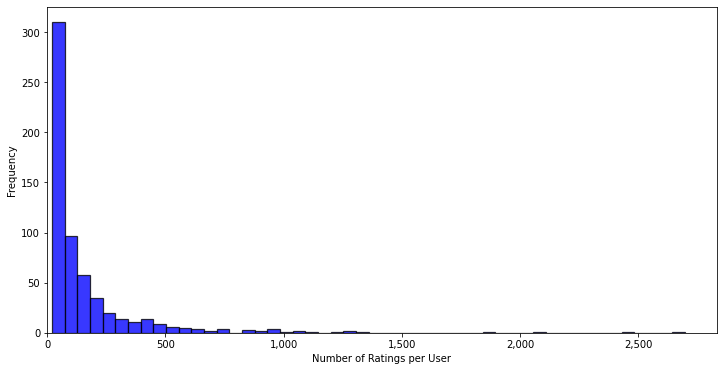

In [59]:
f, ax = plt.subplots(figsize=(12,6))
userRatingGroup = ratingsPrepare.groupby("userId").agg({"rating":"count"})

userRatingGroup = list(userRatingGroup.select("count(rating)").rdd.flatMap(lambda x: x).collect())
plt.hist(userRatingGroup,bins=50,color='blue', edgecolor='black',
                     linewidth=1.25, alpha=0.78)
ax.set_xlabel('Number of Ratings per User')
ax.set_ylabel('Frequency')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()


*We see that a large section (almost all) fall under the category 0-500 ratings. This skewed data is a reason for the lack of data for a lot of users which is causing error in the modelling for all those users. This presents a picture that inspite having such a huge data, only a handfull of users have actually contributed substantially.*

**Our second plot, we see the relation between the Number of Ratings per movie and its Frequency.**

/state/partition1/job-19665852/ipykernel_3480370/396308077.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
/state/partition1/job-19665852/ipykernel_3480370/396308077.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


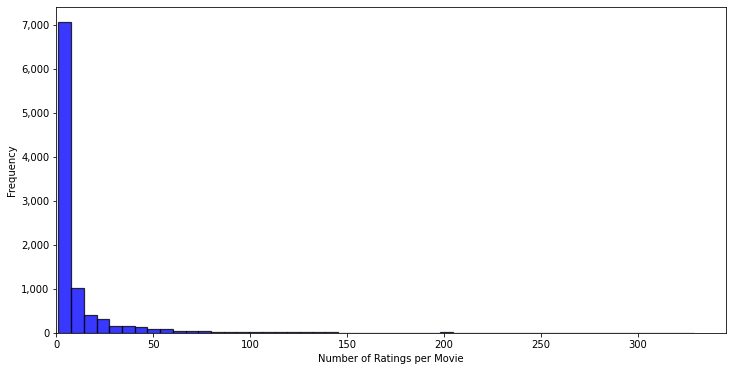

In [64]:
f, ax = plt.subplots(figsize=(12,6))
movieRatingGroup = ratingsPrepare.groupby("movieId").agg({"rating":"count"})
movieRatingGroup = list(movieRatingGroup.select("count(rating)").rdd.flatMap(lambda x: x).collect())
plt.hist(movieRatingGroup,bins=50,color='blue', edgecolor='black',
                     linewidth=1.25, alpha=0.78)
ax.set_xlabel('Number of Ratings per Movie')
ax.set_ylabel('Frequency')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

*This is an ideal plot which gives us a clear picture that some movies have more number of reviews than others. This clearly show how some movies can be modelled better than others. With more data available and more reviews available for certain movies, others with lesser count cause an error. So this presents a picture that inspite having such a huge dataset, a large number of ratings exist only for a fraction of movies.*

**Our next plot, shows the relation between different user movie ratings and its corresponidng number of users.**

/state/partition1/job-19665852/ipykernel_3480370/2841329552.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


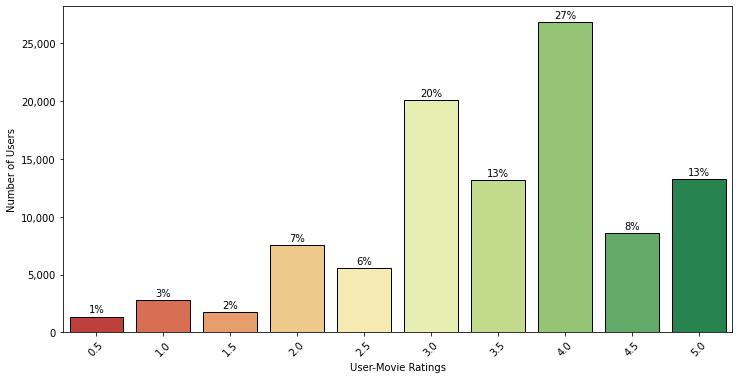

In [65]:
import seaborn as sns
Ratings = ratingsPrepare.groupby('rating').count().toPandas()
movieRatingDistGroup =  Ratings.sort_index() \
                                             .reset_index()

# Create Matplotlib Figure
fig, ax = plt.subplots(figsize=(12,6))

# Main Figure: Seaborn Barplot
sns.barplot(data=movieRatingDistGroup, x='rating', y='count',
            palette='RdYlGn', edgecolor="black", ax=ax)

# Set Xaxis and Yaxis
ax.set_xlabel("User-Movie Ratings")
ax.set_ylabel('Number of Users')
ax.xaxis.set_tick_params(rotation=45)

# Thousand separator on Yaxis labels
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# Add percentage text on top of each bar
total = float(movieRatingDistGroup['count'].sum())

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+350,
            '{0:.0%}'.format(height/total),
            ha="center") 

# Display plot
plt.show()


*From this plot, we can clearly see that users tend to be more concentrated towards mid ratings. Users tend to give an average verdict to movies. Both the extremes, 0.5 rating and 5 rating are tougher to get and among these two, its even harder to get a user to give 0.5 rating. This skewness towrds mid and above shows users try to balance and not give very bad rating to any movie.* 

+-------+------+------+-------------+-------------+--------------------+--------------------+
|movieId|userId|rating|ratingsScaled|ratingsBinary|               title|              genres|
+-------+------+------+-------------+-------------+--------------------+--------------------+
|      1|     1|   4.0|          1.5|          1.0|    Toy Story (1995)|Adventure|Animati...|
|      3|     1|   4.0|          1.5|          1.0|Grumpier Old Men ...|      Comedy|Romance|
|      6|     1|   4.0|          1.5|          1.0|         Heat (1995)|Action|Crime|Thri...|
|     47|     1|   5.0|          2.5|          1.0|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|   5.0|          2.5|          1.0|Usual Suspects, T...|Crime|Mystery|Thr...|
+-------+------+------+-------------+-------------+--------------------+--------------------+
only showing top 5 rows



/state/partition1/job-19665852/ipykernel_3480370/44911690.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


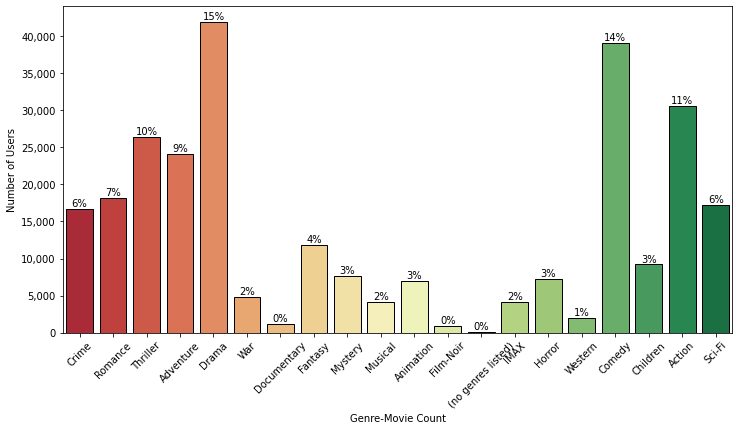

In [74]:
import seaborn as sns

Ratings = ratingsPrepare.join(movies, on='movieId')

Ratings.show(5)

udf_genres_list = F.udf(lambda x: [i for i in x.split('|')], ArrayType(StringType()))


genresData = Ratings.withColumn('genres', F.explode(udf_genres_list(F.col('genres')))) 

genresCount = genresData.groupby('genres').count().toPandas()
genresCount =  genresCount.sort_index() \
                                             .reset_index()

# Create Matplotlib Figure
fig, ax = plt.subplots(figsize=(12,6))

# Main Figure: Seaborn Barplot
sns.barplot(data=genresCount, x='genres', y='count',
            palette='RdYlGn', edgecolor="black", ax=ax)

# Set Xaxis and Yaxis
ax.set_xlabel("Genre-Movie Count")
ax.set_ylabel('Number of Users')
ax.xaxis.set_tick_params(rotation=45)

# Thousand separator on Yaxis labels
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# Add percentage text on top of each bar
total = float(genresCount['count'].sum())

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+350,
            '{0:.0%}'.format(float(height/total)),
            ha="center") 

# Display plot
plt.show()



*From this plot, we can clearly see that users tend to prefer Drama and Comedy over other genres.So this biasness towards these genres causes a limited number of reviews for other genres. Hence, causing an imperfect modelling.* 

/state/partition1/job-19665852/ipykernel_3480370/761062920.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(float(x)) for x in ax.get_yticks().tolist()])


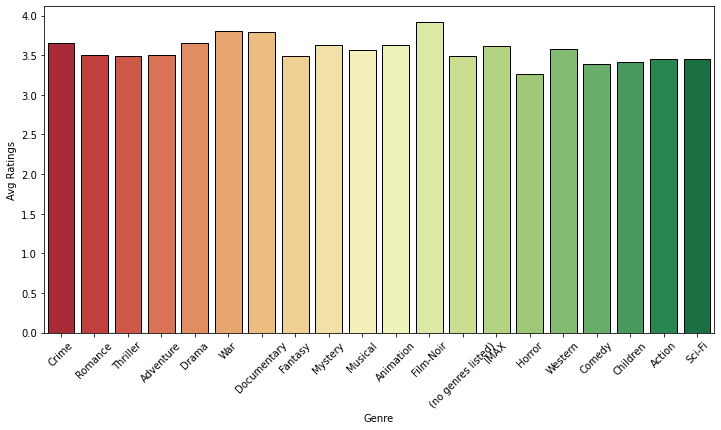

In [63]:
genresRatings = genresData.groupby('genres').agg({'rating':'avg'}).toPandas()

genresRatings.head(5)

# Create Matplotlib Figure
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(data=genresRatings, x='genres', y='avg(rating)',
            palette='RdYlGn', edgecolor="black", ax=ax)

# Set Xaxis and Yaxis
ax.set_xlabel("Genre")
ax.set_ylabel('Avg Ratings')
ax.xaxis.set_tick_params(rotation=45)

# Thousand separator on Yaxis labels
ax.set_yticklabels(['{:,}'.format(float(x)) for x in ax.get_yticks().tolist()])

# Display plot
plt.show()

*Average rating for each genre gives us an understand as to how different genres are preferred rating wise. In corellation with the above plot, we can deduce about the nature of rating, count of rating from different users. These plot can help in overall interpretation of the dataset and building a recommendation system* 